# Расширенный фильтр Калмана (EKF)

Робот начинает движение в стартовой точке (0, 0) и двигается по окружности постоянного радиуса с постоянной скоростью до промежуточной точки, а затем продолжает движение по другой окружности, пока не достигнет финиша.
Для определения положения робота необходимо использовать данные с проприоцептивных сенсоров, а именно расстояние до ориентиров. Ориентиры статичны, то есть имеют постоянное и известное положение в пространстве. Однако данные с сенсора поступают с некоторым шумом, в связи с чем необходимо реализовать расширенный фильтр Калмана для уменьшения уровня ошибки и более точного определения положения робота.

Уравнения изменения состояния робота:

$
\mathbf{x} =
\begin{bmatrix}
x + v \cos(\theta) \, dt \\
y + v \sin(\theta) \, dt \\
\theta + \omega \, dt
\end{bmatrix}
$

Уравнения для измерений с ориентиров:

$
\mathbf{z}_t^i =
\begin{bmatrix}
r_t^i \\
\phi_t^i
\end{bmatrix}
= \begin{bmatrix}
\sqrt{(m_{j,x} - x)^2 + (m_{j,y} - y)^2} \\
\text{atan2}(m_{j,y} - y, m_{j,x} - x) - \theta
\end{bmatrix} + \mathcal{N}(0, \mathbf{R})$

где $z$ — вектор измерений; $r$ — измеренное расстояние до ориентира; $θ$ — угол, измеренный против часовой стрелки от робота до ориентира, от фиксированной оси, которая называется полярной осью; $m_x$ и $m_y$ — координаты ориентира на карте; $N(0, R)$ — нормально распределённый шум с ковариацией $R$.

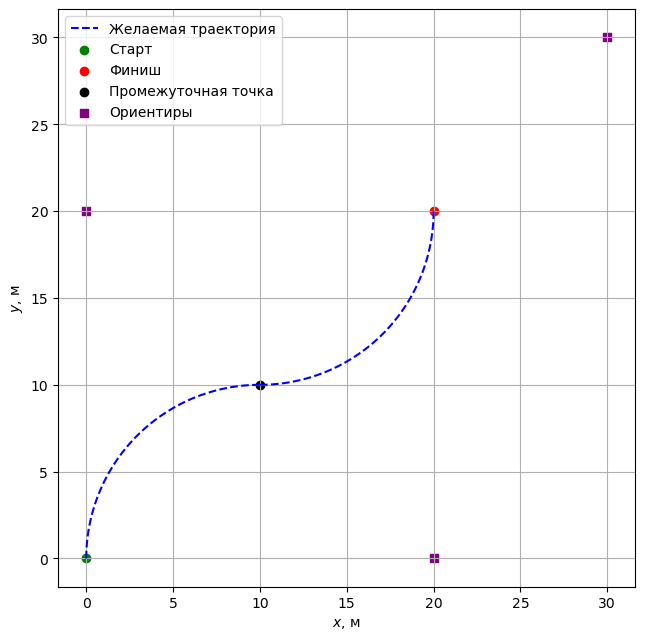

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Radius = 10 # Радиус окружности
A = np.array([[0], [0]]) # Начальная точка
B = np.array([[2 * Radius], [2 * Radius]]) # Конечная точка
C = np.array([[Radius], [Radius]]) # Промежуточная точка

landmarks = np.array([[2 * Radius, 0], [0, 2 * Radius], [3 * Radius, 3 * Radius]]) # Ориентиры

# Функция для построения желаемой траектории
def draw_desired_trajectory(ax):
    ax.scatter(A[0], A[1], color='green', label='Старт')
    ax.scatter(B[0], B[1], color='red', label='Финиш')
    ax.scatter(Radius, Radius, color='black', label="Промежуточная точка")

    angle1 = np.linspace(-np.pi, -3 * np.pi/2, 100)
    x1 = Radius * np.cos(angle1) + Radius
    y1 = Radius * np.sin(angle1)
    ax.plot(x1, y1, '--', color='blue')

    angle2 = np.linspace(-np.pi / 2, 0, 100)
    x2 = Radius * np.cos(angle2) + Radius
    y2 = Radius * np.sin(angle2) + Radius * 2
    ax.plot(x2, y2, '--', color='blue', label="Желаемая траектория")

    ax.scatter(landmarks[:, 0], landmarks[:, 1], marker='s', color='purple', label="Ориентиры")
    ax.set_xlabel(f"$x$, м")
    ax.set_ylabel(f"$y$, м")

    ax.grid()
    ax.set_aspect('equal')

fig, ax = plt.subplots(figsize=(7.5, 7.5))
draw_desired_trajectory(ax)
ax.legend()

## Выпишем шаги алгоритма EKF

Предположим, что модель изменения состояния и модель наблюдения (измерений) выглядят следующим образом:<br/>
$\mathbf{x}_k = f(\mathbf{x}_{k-1}, \mathbf{u}_{k-1}) + \mathbf{w}_{k-1}$<br/>
$\mathbf{z}_k = h(\mathbf{x}_k) + \mathbf{v}_k$

где:
- $\mathbf{x}$ — состояние системы;
- $\mathbf{z}$ — реальные измерения с экстероцептивных сенсоров;
- $\mathbf{u}$ — сигналы управления;
- $\mathbf{w}$ и $\mathbf{v}$ — многомерные гауссовские шумы с нулевым средним и ковариацией $\mathbf{Q}$ и $\mathbf{R}$$соответственно.

1. Предположим, у нас есть начальное предсказание о положении робота: $ \hat{x}_{0|0} $. Также мы знаем начальную ковариацию состояния:$\quad P_{0|0}$‌. <br/>Здесь ноль слева обозначает номер предсказаний с проприоцептивного сенсора (например, колёсной одометрии), а ноль справа — номер предсказания с экстероцептивного сенсора (например, системы GNSS).

3. На основе сигналов управления, пришедших с проприоцептивного сенсора, и с помощью нелинейной функции состояния робота мы получаем априорное предсказание о следующем состоянии системы.<br/>‌$ \hat{x}_{k|k-1} = f(\hat{x}_{k-1|k-1},<br/> u_{k-1}) $

3. Теперь необходимо вычислить матрицу Якоби — матрицу, составленную из разных частных производных по переменным состояния и переменным управления робота:<br/>$ F_k = \frac{\partial f}{\partial x} \bigg|_{\hat{x}_{k-1|k-1}, u_{k-1}}$
‌Например, если состояние робота задаётся переменными (x, y, theta), размерность матрицы Якоби будет n × 3, где n — это размерность нелинейной функции состояния. Выражение будет выглядеть следующим образом:<br/>$
\mathbf{F} =
\begin{bmatrix}
\frac{\partial f}{\partial x} & \frac{\partial f}{\partial y} & \frac{\partial f}{\partial \theta}
\end{bmatrix}
$                                                                                                                           
4. Посчитаем обновлённую ковариацию с учётом статичной ковариации Q (то есть шума).<br/> $P_{k|k-1} = F_k P_{k-1|k-1} F_k^T + Q_{k-1}$ <br/>Примечание: если в функции оценки состояния f есть переменные управления (например, угол поворота колеса или линейная скорость), не забудьте их включить в матрицу Якоби. В этом случае размерности ковариаций и Якоби будут больше.

5. Считаем разницу между восприятием и априорным предсказанием (residual).<br/> $\tilde{y}_k = z_k - h(\hat{x}_{k|k-1})$

6. Считаем Якоби для нелинейной функции измерений h:<br/> $H_k = \frac{\partial h}{\partial x} \bigg|_{\hat{x}_{k|k-1}}$<br/>
Примечание: в этом случае производную берём только по переменным состояния.

7. Находим Kalman Gain. Он показывает, какому предсказанию мы доверяем больше, то есть на какой коэффициент нам нужно умножить априорное предсказание, чтобы получить наиболее вероятное состояние робота.<br/>
$S_k = H_k P_{k|k-1} H_k^T + R_k$ <br/>
$K_k = P_{k|k-1} H_k^T S_k^{-1}$

8. Теперь необходимо получить новое апостериорное предсказание (предсказание с учётом слияния двух сенсоров). <br/>$\hat{x}_{k|k} = \hat{x}_{k|k-1} + K_k \tilde{y}_k$
‌Это предсказание — актуальное предположение о нахождении робота в момент времени k.

9. Осталось обновить апостериорную ковариацию. ‌<br/>$P_{k|k} = (I - K_k H_k) P_{k|k-1}$

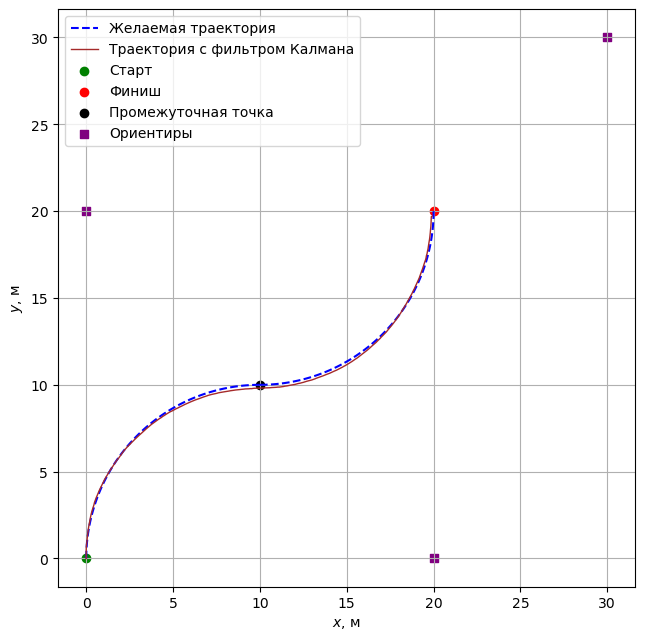

In [2]:
# C - точка между полуокржностями, где робот должен поменять знак угловой скорости
# В - конечная точка
desired_points = [0, np.pi/2] # Желаемые точки
cur_des_point_idx = 0 # Индекс точки, к которой робот сейчас стремится
error_threshold = .01 # Погрешность ошибки

track = [A] # Положение робота в каждый момент времени
# В начале робот находится в точке А и "смотрит" наверх
# поэтому первое положение в списке это точка А и угол поворота pi/2

ang_vel = 0.5 # Угловая скорость
v = 5.0
dt = 0.01 # delta t (Временной шаг)
num_of_iterations = 10000 # Количество итераций

P = np.eye(3)          # Ковариация ошибки
R = np.eye(2)          # Ковариация измерений
# Q = np.eye(3)          # Ковариация изменения состояния
Q = np.diag([0.1, 0.1, 0.01])
y = np.zeros((2, 1))   # Residual (разность, остаток)
z = np.array([None]*2) # Измерения относительно ориентиров
K = np.zeros((3, 1))   # Прирост Калмана
_I = np.eye(3)         # Единичная матрица
F = np.eye(3)          # Матрица Якоби состояния

std_rng = 0.01 # Погрешность положения
std_brg = 0.01 # Погрешность ориентации
car_pos = np.vstack((A, np.pi/2)) # Начальное положение

steps = [0]

# Движение робота 
for i in range(num_of_iterations):
    # Если достигли всех желаемых точек из списка, то цикл прекращается
    if cur_des_point_idx > 1:
        break
    # Найдём расстояние между роботом и текущей желаемой точкой
    theta = car_pos[-1]
    # Если расстояние меньше заданного порога, то переключаемся на следующую точку
    # а так же обозначаем, что в данный момент робот расположен горизонтально (для увеличения точности)
    if abs(theta - desired_points[cur_des_point_idx]) < error_threshold:
        cur_des_point_idx += 1
        car_pos[2] = 0 

        # Смена знака угловой скорости
        if cur_des_point_idx == 1:  # При достижении точки C
            ang_vel = -ang_vel
        
        steps.append(i)

    # ИМПЛЕМЕНТАЦИЯ
    
    # Предсказание состояния
    x_pos, y_pos, theta = car_pos
    x_pos[0] += np.cos(theta[0]) * v * dt
    y_pos[0] += np.sin(theta[0]) * v * dt
    theta[0] -= ang_vel * dt
    car_pos = np.array([x_pos, y_pos, theta])

    # Вычисление матрицы Якоби
    F = np.array([
        [1, 0, -np.sin(theta[0]) * v * dt],
        [0, 1, np.cos(theta[0]) * v * dt],
        [0, 0,  1]
    ])  

    # Предсказание ковариации
    P = F @ P @ F.T + Q

    for lmark in landmarks:
        d = np.linalg.norm(np.array((x_pos, y_pos)) - lmark)
        a = np.arctan2(lmark[1] - y_pos[0], lmark[0] - x_pos[0]) - theta[0]
        z = np.array([[d + np.random.randn() * std_rng],
                      [a + np.random.randn() * std_brg]])
        
        Hx = np.array([[d],
                       [a]])
        H =  np.array([[-(lmark[0] - x_pos[0]) / d, -(lmark[1] - y_pos[0]) / d, 0],
                       [ (lmark[1] - y_pos[0]) / d**2,  -(lmark[0] - x_pos[0]) / d**2, -1]])
         
        # ИМПЛЕМЕНТАЦИЯ 
        
        # Вычисление разницы между измерениями и предсказанием 
        y = z - Hx

        # Вычисление ковариации измерений S
        S = H @ P @ H.T + R

        # Вычисление Kalman Gain
        K = P @ H.T @ np.linalg.inv(S)

        # Обновление состояния
        car_pos += K @ y

        # Обновление ковариации
        P = (_I - K @ H) @ P

    # Добавляем текущее положение робота в трек
    track.append(car_pos[:2])

# Преобразуем track в numpy array для визуализации
track = np.array(track)

# Построение траектории
fig, ax = plt.subplots(figsize=(7.5, 7.5))
draw_desired_trajectory(ax)

# Отображение траектории с фильтром Калмана
ax.plot(track[:, 0], track[:, 1], linewidth=1, color='brown', label="Траектория с фильтром Калмана")
ax.legend()
plt.show()